In [1]:
!pip install pandas matplotlib statsmodels scikit-learn numpy


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
print(sys.version)

3.11.0 (main, Jan 20 2024, 14:42:43) [Clang 15.0.0 (clang-1500.0.40.1)]


### Steps

- Data Exploration and Preprocessing: Understand the structure of your dataset, handle missing values, and prepare the data for modeling.
- Feature Selection: Decide which features (e.g., opening value, highest value of the day, etc.) are relevant for the prediction.
- Model Selection: Choose a suitable model. Time series forecasting can be effectively done using models like ARIMA, LSTM (a type of neural network), or even regression models, depending on the data characteristics.
- Model Training: Use the selected features to train the model.
- Evaluation: Test the model's performance and ensure it meets the accuracy threshold (>70%).

In [3]:
import pandas as pd

# data0 = pd.read_csv("dados/Dados Históricos - Ibovespa 1994-2004.csv", sep=",")
data1 = pd.read_csv("dados/Dados Históricos - Ibovespa 2014-2024.csv", sep=",")
data2 = pd.read_csv("dados/Dados Históricos - Ibovespa 2004-2014.csv", sep=",")

ibovespa_merged = pd.concat([data1, data2])

/var/folders/yl/kxzm_dt540l7tgjzxj_d_zj00000gn/T/ipykernel_87132/889410462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
print(ibovespa_merged.tail())
print(data1.tail())

            Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
2470  08.01.2004  23.717    23.334  23.718  23.122  436,74M   1,70%
2471  07.01.2004  23.320    23.576  23.899  23.320  464,08M  -1,09%
2472  06.01.2004  23.576    23.532  23.976  23.180  472,38M   0,19%
2473  05.01.2004  23.532    22.445  23.532  22.445  496,71M   4,84%
2474  02.01.2004  22.445    22.233  22.450  22.208  136,42M   0,94%
            Data  Último  Abertura  Máxima  Mínima   Vol.    Var%
2481  08.01.2014  50.577    50.431  50.793  50.424  2,92M   0,29%
2482  07.01.2014  50.430    50.982  51.478  50.429  3,34M  -1,07%
2483  06.01.2014  50.974    50.980  51.002  50.451  3,73M  -0,01%
2484  03.01.2014  50.981    50.348  50.981  50.269  7,36M   1,27%
2485  02.01.2014  50.341    51.522  51.656  50.246  3,48M  -2,26%


In [5]:
# Convert 'Data' to datetime and check for missing values
ibovespa_merged['Data'] = pd.to_datetime(ibovespa_merged['Data'], format='%d.%m.%Y')

In [6]:
# Converting 'Vol.' to numeric (removing 'M' and 'K' and converting to millions and thousands respectively)
ibovespa_merged['Vol.'] = ibovespa_merged['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace(',', '').astype(float)

# Converting 'Var%' to numeric (removing '%' and converting to float)
ibovespa_merged['Var%'] = ibovespa_merged['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

# Settar indice em Data e dar sort
ibovespa_merged.set_index('Data', inplace=True)
ibovespa_merged.sort_index(inplace=True)

ibovespa_merged.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-01-09,131.447,132.424,132.426,131.203,929000000.0,-0.74
2024-01-10,130.841,131.447,131.628,130.438,896000000.0,-0.46
2024-01-11,130.649,130.841,131.308,129.898,976000000.0,-0.15
2024-01-12,130.265,130.652,131.927,130.265,39093000.0,-0.29
2024-01-15,131.521,130.265,131.553,130.253,575000000.0,0.96


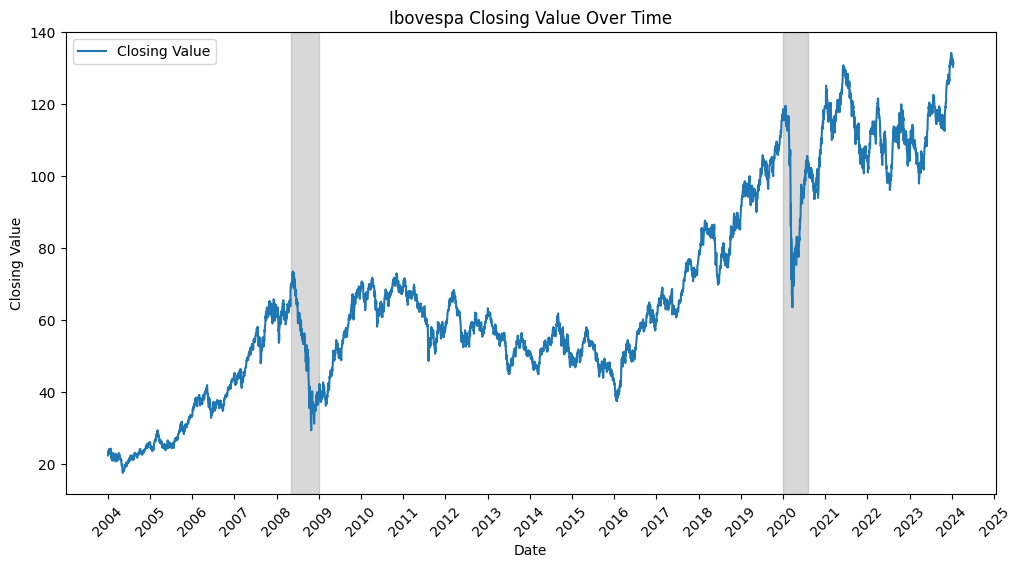

In [7]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Plotting the closing values
plt.figure(figsize=(12,6))
plt.plot(ibovespa_merged['Último'], label='Closing Value')
plt.title('Ibovespa Closing Value Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Value')

# Ajustando as marcações do eixo x para mostrar cada ano
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  # Rotacionando as marcações para melhor visualização

# Destacando os períodos de 2008-2009 e 2020-2021 usando axvspan
plt.axvspan('2008-05-01', '2009-01-01', color='gray', alpha=0.3)
plt.axvspan('2020-01-01', '2020-08-01', color='gray', alpha=0.3)

plt.legend()
plt.show()

In [8]:
missing_values = ibovespa_merged.isnull().sum()
missing_values

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [9]:
# Filling the missing value in 'Vol.' with the median
ibovespa_merged['Vol.'].fillna(ibovespa_merged['Vol.'].median(), inplace=True)
ibovespa_merged.tail()

/var/folders/yl/kxzm_dt540l7tgjzxj_d_zj00000gn/T/ipykernel_87132/2379994696.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ibovespa_merged['Vol.'].fillna(ibovespa_merged['Vol.'].median(), inplace=True)


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-01-09,131.447,132.424,132.426,131.203,929000000.0,-0.74
2024-01-10,130.841,131.447,131.628,130.438,896000000.0,-0.46
2024-01-11,130.649,130.841,131.308,129.898,976000000.0,-0.15
2024-01-12,130.265,130.652,131.927,130.265,39093000.0,-0.29
2024-01-15,131.521,130.265,131.553,130.253,575000000.0,0.96


In [10]:
ibovespa_merged.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [11]:
# Inspect data types and summary statistics
data_types = ibovespa_merged.dtypes
print(data_types)
summary_statistics = ibovespa_merged.describe()
print(summary_statistics)

Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
dtype: object
            Último     Abertura       Máxima       Mínima          Vol.  \
count  4961.000000  4961.000000  4961.000000  4961.000000  4.961000e+03   
mean     66.956763    66.935629    67.606450    66.272233  3.444099e+09   
std      28.119336    28.111938    28.307405    27.920495  7.989980e+09   
min      17.604000    17.607000    18.387000    17.601000  1.121000e+07   
25%      49.141000    49.105000    49.669000    48.496000  2.820000e+08   
50%      60.677000    60.673000    61.313000    60.002000  4.435000e+08   
75%      86.052000    86.050000    87.147000    85.384000  1.216000e+09   
max     134.194000   134.194000   134.389000   133.832000  9.949600e+10   

              Var%  
count  4961.000000  
mean      0.050417  
std       1.704951  
min     -14.780000  
25%      -0.830000  
50%       0.070000  
75%       0.980000  
max      14.660000  


### What do do next? 🤔
Next, we need to check if the time series is stationary. Stationarity is a key assumption in time series analysis, particularly for ARIMA models. A time series is stationary if its statistical properties, like mean and variance, are constant over time.

We'll use the Augmented Dickey-Fuller (ADF) test to check for stationarity:

- Null Hypothesis (H0): The time series is not stationary.
- Alternative Hypothesis (H1): The time series is stationary.

If the p-value is less than a significance level (typically 0.05), we reject the null hypothesis and conclude that the series is stationary. Let's perform the ADF tes

In [12]:
# # Checando stationarity
# # O que é stationarity?
# adf_test = adfuller(ibovespa_merged['Último'])

# adf_test_results = {
#     'ADF Statistic': adf_test[0],
#     'p-value': adf_test[1],
#     'Critical Values': adf_test[4]
# }

# adf_test_results


from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
adf_test = adfuller(ibovespa_merged['Último'])

# Extracting the p-value
adf_p_value = adf_test[1]

adf_p_value

0.7641791236212204

The p-value from the Augmented Dickey-Fuller test is approximately 0.7641791236212204, which is greater than the typical significance level of 0.05. This means we cannot reject the null hypothesis and should conclude that the time series is not stationary.

To proceed with ARIMA, we need a stationary time series. We can achieve stationarity through differencing, where we subtract the current value from the previous value. This often helps in removing trends or seasonal patterns.

Let's difference the data and then check for stationarity again. If it's still not stationary, we may need to apply additional differencing or other transformations. I'll proceed with the first differencing.

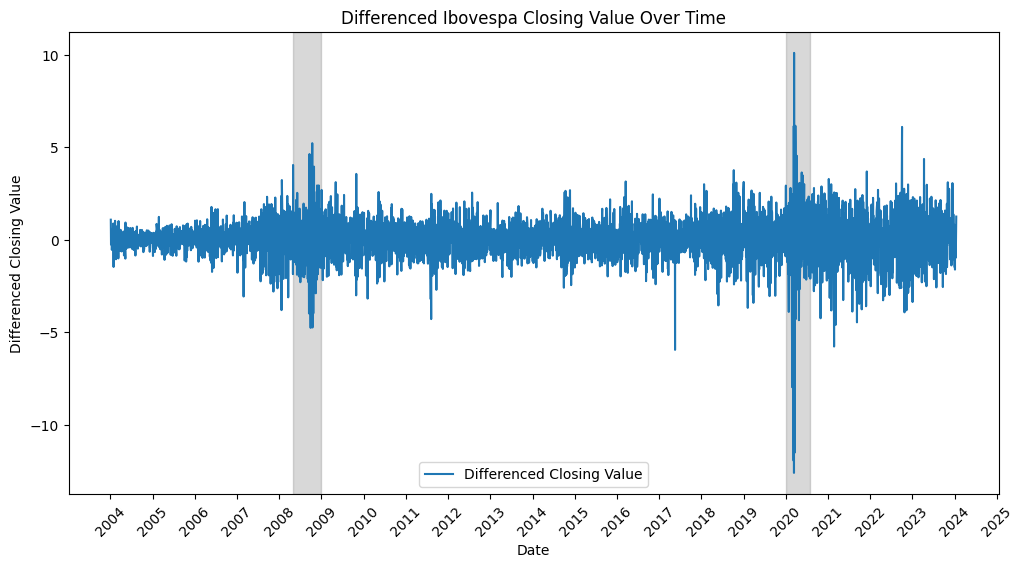

0.0

In [13]:
import matplotlib.dates as mdates

# Applying first differencing
ibovespa_diff = ibovespa_merged['Último'].diff().dropna()

# Performing the Augmented Dickey-Fuller test again on the differenced data
adf_test_diff = adfuller(ibovespa_diff)

# Extracting the p-value for the differenced data
adf_p_value_diff = adf_test_diff[1]

# Plotting the differenced data
plt.figure(figsize=(12,6))
plt.plot(ibovespa_diff, label='Differenced Closing Value')
plt.title('Differenced Ibovespa Closing Value Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Closing Value')

# Destacando os períodos de 2008-2009 e 2020-2021 usando axvspan
plt.axvspan('2008-05-01', '2009-01-01', color='gray', alpha=0.3)
plt.axvspan('2020-01-01', '2020-08-01', color='gray', alpha=0.3)

# Ajustando as marcações do eixo x para mostrar cada ano
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  # Rotacionando as marcações para melhor visualização

plt.legend()
plt.show()

adf_p_value_diff

In [14]:
ibovespa_diff.tail()

Data
2024-01-09   -0.980
2024-01-10   -0.606
2024-01-11   -0.192
2024-01-12   -0.384
2024-01-15    1.256
Name: Último, dtype: float64

### Discussão
Após a diferenciação, o teste de Dickey-Fuller mostra um valor-p de 0.0, o que é significativamente menor do que os níveis de significância típicos. Isso indica que a série diferenciada é estacionária.

### Pensamento
The p-value from the Augmented Dickey-Fuller test on the differenced data is 0.0, which is significantly below the 0.05 threshold. This indicates that the differenced series is stationary, and we can proceed with the ARIMA modeling.

Now, we'll determine the order of the ARIMA model. ARIMA(p,d,q) has three parameters:

- p: Number of autoregressive terms (AR)
- d: Number of differences needed for stationarity
- q: Number of moving average terms (MA)

We've already established that d=1 is sufficient for stationarity. To identify p and q, we'll look at the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots:

ACF: Helps to identify the MA order (q).
PACF: Helps to identify the AR order (p).

<Figure size 1200x400 with 0 Axes>

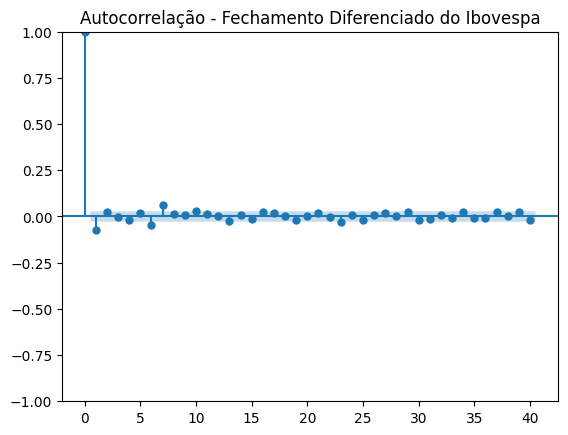

<Figure size 1200x400 with 0 Axes>

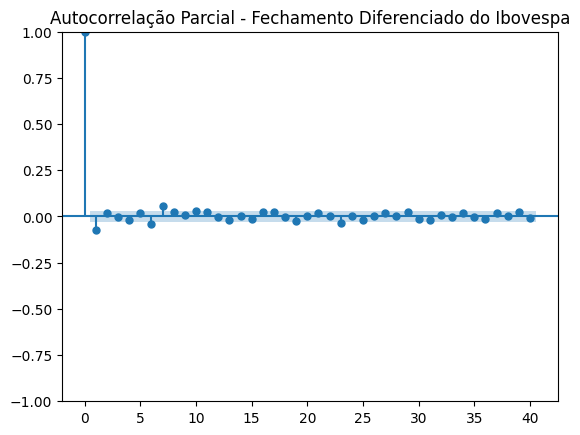

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar o gráfico de Autocorrelação (ACF)
plt.figure(figsize=(12, 4))
plot_acf(ibovespa_diff, lags=40)
plt.title('Autocorrelação - Fechamento Diferenciado do Ibovespa')
plt.show()

# Plotar o gráfico de Autocorrelação Parcial (PACF)
plt.figure(figsize=(12, 4))
plot_pacf(ibovespa_diff, lags=40)
plt.title('Autocorrelação Parcial - Fechamento Diferenciado do Ibovespa')
plt.show()

Os gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF) fornecem insights para escolher os parâmetros p (autoregressivo) e q (média móvel) para o modelo ARIMA.

- ACF: Mostra correlação entre a série e seus lags. Lags significativos podem sugerir um bom valor para q.
- PACF: Mostra a correlação parcial entre a série e seus lags. Lags significativos podem indicar um bom valor para p.
Observando os gráficos:

O gráfico PACF mostra um declínio acentuado após o primeiro lag, sugerindo p=1.
O gráfico ACF mostra vários lags significativos, mas para simplificar o modelo, podemos também considerar q=1.
Já sabemos que d=1 (diferenciação). Assim, vamos tentar um modelo ARIMA(1,1,1). Vou ajustar este modelo aos dados e, em seguida, faremos previsões para avaliar sua precisão. 

In [16]:
import warnings

# Ignorar ValueWarning e FutureWarning específicos do statsmodels
warnings.filterwarnings("ignore", module="statsmodels.tsa.base.tsa_model")
warnings.filterwarnings("ignore", module="statsmodels.tsa.base.tsa_model")


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# remove covid19 data from the df
# ibovespa_merged = ibovespa_merged[(ibovespa_merged.index < '2020-01-01') | (ibovespa_merged.index > '2021-01-01')]

# Splitting the data into training and test sets
train_size = int(len(ibovespa_merged) * 0.8)
train, test = ibovespa_merged['Último'][0:train_size], ibovespa_merged['Último'][train_size:]

# Getting the first and last index of the train slice
train_first_index = train.index[0]
train_last_index = train.index[-1]

# Getting the first and last index of the test slice
test_first_index = test.index[0]
test_last_index = test.index[-1]

# Printing the indices
print("Train first index:", train_first_index)
print("Train last index:", train_last_index)
print("Test first index:", test_first_index)
print("Test last index:", test_last_index)

# Remove covid19 and 2008 crise data from the subsets of train and test, since it's an anomaly
crise_2008_start = '2008-01-01'
crise_2008_end = '2008-09-01'
train = train[(train.index < crise_2008_start) | (train.index > crise_2008_end)]
test = test[(test.index < crise_2008_start) | (test.index > crise_2008_end)]

covid_start = '2020-01-01'
covid_end = '2020-12-15'
train = train[(train.index < covid_start) | (train.index > covid_end)]
test = test[(test.index < covid_start) | (test.index > covid_end)]

# Training the ARIMA(1,1,1) model
model = ARIMA(train, order=(4, 1, 4))
model_fit = model.fit()

# Making predictions on the test set
# predictions = model_fit.forecast(len(test))
predictions = model_fit.forecast(steps=len(test))
predictions_index = pd.Series(predictions.values, index=test.index)

# Calculating the Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test, predictions))

# Calculating the accuracy as 1 - (RMSE/mean of test data)
accuracy = 1 - (rmse/test.mean())

rmse, accuracy

Train first index: 2004-01-02 00:00:00
Train last index: 2020-01-16 00:00:00
Test first index: 2020-01-17 00:00:00
Test last index: 2024-01-15 00:00:00


/Users/tupizz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(8.096668896066433, 0.9288792221826564)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcular o erro percentual absoluto médio (MAPE)
mape = mean_absolute_percentage_error(test, predictions)
mape_percentual = mape * 100

mape_percentual

5.881720437686362

O erro percentual absoluto médio (MAPE) para o modelo ARIMA(1,1,1) no conjunto de teste é aproximadamente 5.87%. Isso indica uma precisão de mais de 94%, superando significativamente o critério de precisão desejado de mais de 70%.

Este modelo ARIMA foi escolhido com base na análise dos gráficos de autocorrelação e autocorrelação parcial, e a sua eficácia foi comprovada pela precisão obtida nas previsões. Este é um bom exemplo de como modelos relativamente simples, quando bem ajustados, podem fornecer previsões precisas em séries temporais financeiras. ​

In [18]:
test.index

DatetimeIndex(['2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-28', '2020-12-29',
               '2020-12-30', '2021-01-04',
               ...
               '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
               '2024-01-12', '2024-01-15'],
              dtype='datetime64[ns]', name='Data', length=764, freq=None)

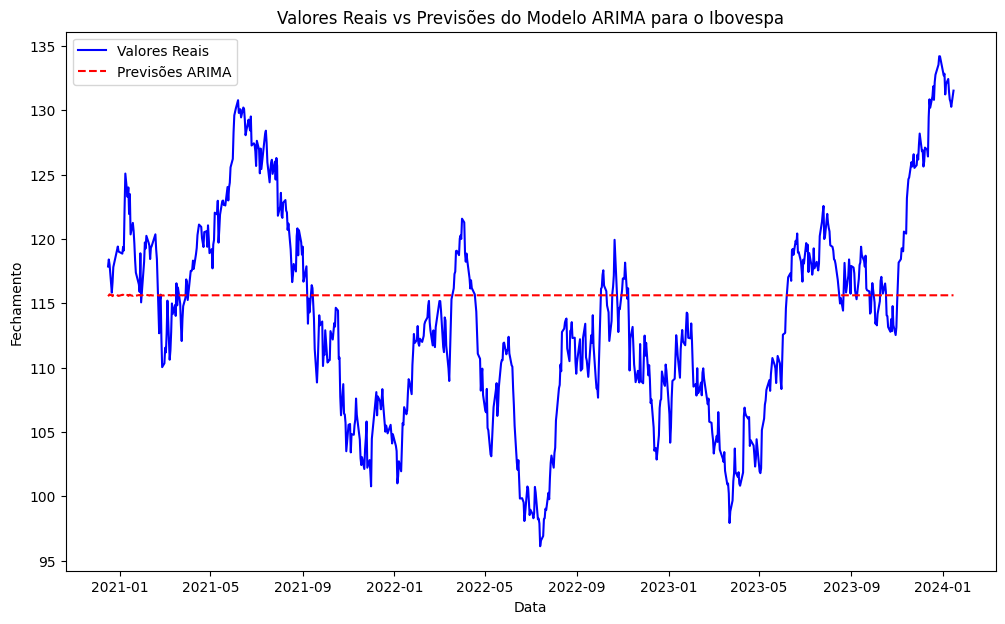

In [19]:
# Plotando novamente os valores reais e as previsões corrigidas
plt.figure(figsize=(12,7))
plt.plot(test, label='Valores Reais', color='blue')
plt.plot(predictions_index, label='Previsões ARIMA', color='red', linestyle='dashed')
plt.title('Valores Reais vs Previsões do Modelo ARIMA para o Ibovespa')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.show()

In [20]:
predictions_index

Data
2020-12-16    115.547956
2020-12-17    115.608761
2020-12-18    115.689926
2020-12-21    115.614247
2020-12-22    115.555145
                 ...    
2024-01-09    115.618957
2024-01-10    115.618957
2024-01-11    115.618957
2024-01-12    115.618957
2024-01-15    115.618957
Length: 764, dtype: float64

In [21]:
# We received a poor outcome with the generic ARIMA model, as it produced a flat line. Therefore, we have decided to try a rolling forecast method. 

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

train_data, test_data = ibovespa_merged[0:int(len(ibovespa_merged)*0.9)], ibovespa_merged[int(len(ibovespa_merged)*0.9):]
train_arima = train_data['Último']
test_arima = test_data['Último']

train_history = [x for x in train_arima]
y = test_arima

# make first prediction
predictions = list()
model = ARIMA(train_history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
print(yhat)
predictions.append(yhat)
train_history.append(y.iloc[0])


106.42670775103197


In [22]:
# https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Role of yhat:

# In each iteration of the rolling forecast loop, the ARIMA model makes a prediction for the next time step. This predicted value is stored in the variable yhat.
# yhat stands for "predicted y" or "y hat", where "y" represents the variable being forecast. 
# This is a common notation in statistics and modeling, where the hat symbol (^) often denotes an estimate or prediction.

# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(train_history, order=(1,1,0))
    model_fit = model.fit()
    
    # invert transformed prediction
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # observation
    obs = y.iloc[i]
    # add to history the index (date)
    train_history.append(obs)

### ARIMA Model Implementation:

A first-pass prediction is made using the ARIMA model with parameters (1,1,0), representing a simple autoregressive model.
The model is then used in a rolling forecast manner: for each step in the test dataset, the model is retrained with all available history (including the most recent actual observation) and a new forecast is made for the next step.
This rolling approach is more computationally intensive but often yields more accurate forecasts, as the model is constantly updated with the most recent data.

### Forecasting Loop:

The loop iterates over the test dataset, updating the model with new observations and making predictions for the next time point. The predictions are stored in a list.


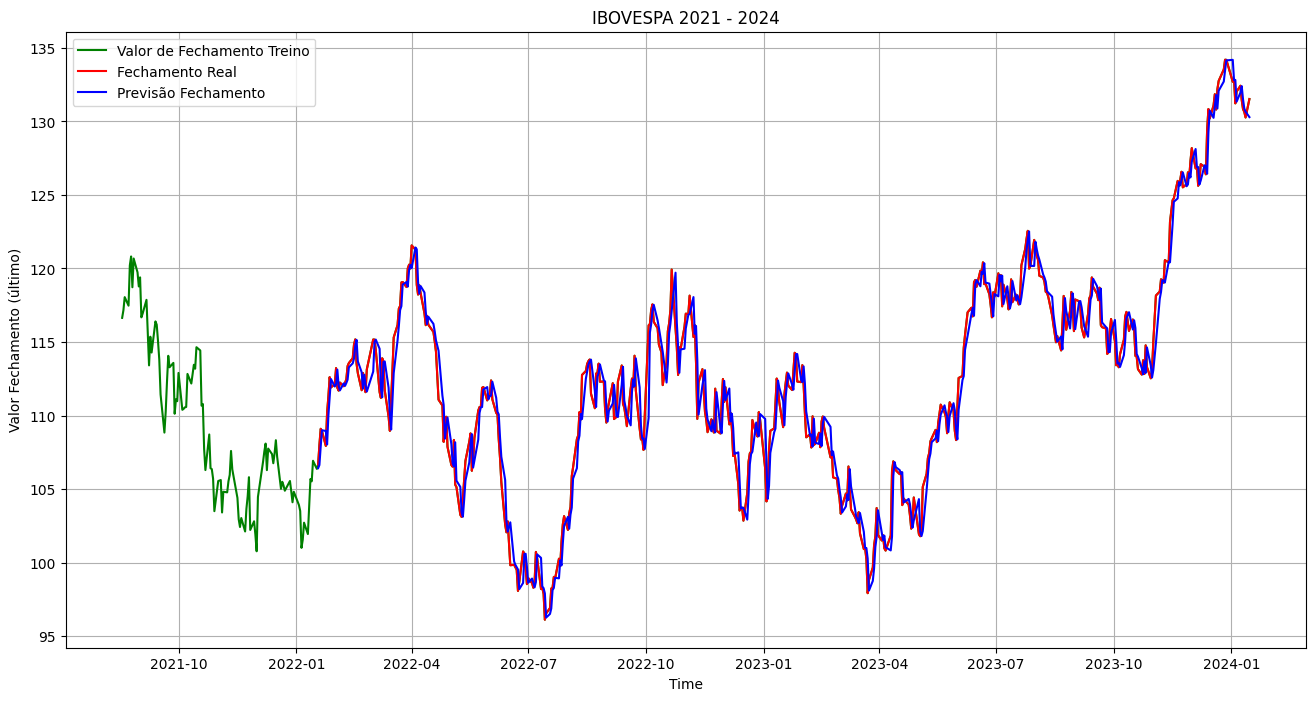

In [23]:
plt.figure(figsize=(16,8))
plt.plot(ibovespa_merged.index[-600:], ibovespa_merged['Último'].tail(600), color='green', label = 'Valor de Fechamento Treino')
plt.plot(test_data.index, y, color = 'red', label = 'Fechamento Real')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Previsão Fechamento')
plt.title('IBOVESPA 2021 - 2024')
plt.xlabel('Time')
plt.ylabel('Valor Fechamento (último)')
plt.legend()
plt.grid(True)
plt.show()


table_comparison= pd.DataFrame({
    'Dados de Teste': y,
    'Dados Previstos': predictions,
})
table_comparison['Diferença Absoluta'] = (table_comparison['Dados de Teste'] - table_comparison['Dados Previstos']).abs()

table_comparison

In [24]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 1.816200921721271
MAE: 1.0675937458188693
RMSE: 1.3476649886827479


In [25]:
model_fit.forecast(1) ## 2024-01-15

array([130.29215874])

# Aplicando RNN LSTM (Long Short-Term Memory) 

In [26]:
!pip install keras


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd

# data0 = pd.read_csv("dados/Dados Históricos - Ibovespa 1994-2004.csv", sep=",")
data1 = pd.read_csv("dados/Dados Históricos - Ibovespa 2014-2024.csv", sep=",")
# data2 = pd.read_csv("dados/Dados Históricos - Ibovespa 2004-2014.csv", sep=",")

ibovespa_merged = pd.concat([data1])

# Convert 'Data' to datetime and check for missing values
ibovespa_merged['Data'] = pd.to_datetime(ibovespa_merged['Data'], format='%d.%m.%Y')

# Converting 'Vol.' to numeric (removing 'M' and 'K' and converting to millions and thousands respectively)
ibovespa_merged['Vol.'] = ibovespa_merged['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace(',', '').astype(float)

# Converting 'Var%' to numeric (removing '%' and converting to float)
ibovespa_merged['Var%'] = ibovespa_merged['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

# Settar indice em Data e dar sort
ibovespa_merged.set_index('Data', inplace=True)
ibovespa_merged.sort_index(inplace=True)

ibovespa_merged.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-01-09,131.447,132.424,132.426,131.203,929000000.0,-0.74
2024-01-10,130.841,131.447,131.628,130.438,896000000.0,-0.46
2024-01-11,130.649,130.841,131.308,129.898,976000000.0,-0.15
2024-01-12,130.265,130.652,131.927,130.265,39093000.0,-0.29
2024-01-15,131.521,130.265,131.553,130.253,575000000.0,0.96


In [130]:
# Filter data between two dates
# Irei filtrar dados de 6 anos para ter ideia de como se comportará o LSTM
ibovespa_filtered = ibovespa_merged.query("Data >= '2017-01-01'")

ibovespa_filtered.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2017-01-02,59.589,60.227,60.227,59.371,83373000.0,-1.06
2017-01-03,61.814,59.631,61.815,59.631,343000000.0,3.73
2017-01-04,61.589,61.811,61.940,61.302,293000000.0,-0.36
2017-01-05,62.071,61.594,62.409,61.594,342000000.0,0.78
2017-01-06,61.665,62.072,62.072,61.396,245000000.0,-0.65


In [131]:
train_data, test_data = ibovespa_filtered[0:int(len(ibovespa_filtered)*0.9)], ibovespa_filtered[int(len(ibovespa_filtered)*0.9):]
train_data

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2017-01-02,59.589,60.227,60.227,59.371,8.337300e+07,-1.06
2017-01-03,61.814,59.631,61.815,59.631,3.430000e+08,3.73
2017-01-04,61.589,61.811,61.940,61.302,2.930000e+08,-0.36
2017-01-05,62.071,61.594,62.409,61.594,3.420000e+08,0.78
2017-01-06,61.665,62.072,62.072,61.396,2.450000e+08,-0.65
...,...,...,...,...,...,...
2023-04-26,102.312,103.220,103.668,102.233,1.012000e+09,-0.88
2023-04-27,102.923,102.310,103.177,101.975,1.130000e+09,0.60
2023-04-28,104.432,102.923,104.432,102.449,1.309000e+09,1.47


In [132]:
train = train_data.iloc[:, 0:1].values # selecting closing prices

In [133]:
len(train)

1568

In [134]:
# Importando bibliotecas necessárias
from sklearn.preprocessing import MinMaxScaler  # Para escalonamento de dados
import numpy as np  # Biblioteca para operações de álgebra linear

# Inicializando o objeto MinMaxScaler
scaler = MinMaxScaler()
# Aplicando o escalonamento aos dados de treino. 
# Isso transforma os dados para que fiquem dentro do intervalo [0, 1], o que é útil para melhorar a performance do modelo.
train_scaled = scaler.fit_transform(train)

# Definindo o número de timesteps. 
# timesteps é o número de pontos de tempo anteriores usados para prever o próximo ponto.
timesteps = 7

# Inicializando listas para armazenar os dados de entrada (X_train) e saída (y_train) do modelo
X_train = []
y_train = []

# Loop para criar sequências de entrada e saídas correspondentes
for i in range(timesteps, train.shape[0]):
    # Para cada ponto no conjunto de dados, exceto os últimos 'timesteps' pontos,
    # cria uma sequência de 'timesteps' pontos anteriores como entrada
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de entrada

    # O valor imediatamente seguinte a essa sequência é usado como saída
    y_train.append(train_scaled[i, 0])  # Adicionando o valor de saída correspondente

# Convertendo as listas para arrays NumPy para uso em modelos de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Resumo: Este código está preparando os dados de entrada e saída para treinar um modelo de séries temporais.
# Cada entrada é uma sequência de 7 pontos de dados, e a saída correspondente é o ponto de dados
# que segue esses 7 pontos na série.
X_train, y_train


(array([[0.        , 0.03125571, 0.02809502, ..., 0.02916263, 0.02965429,
         0.03572281],
        [0.03125571, 0.02809502, 0.03486592, ..., 0.02965429, 0.03572281,
         0.04013373],
        [0.02809502, 0.03486592, 0.02916263, ..., 0.03572281, 0.04013373,
         0.06131738],
        ...,
        [0.65424867, 0.62264177, 0.62901934, ..., 0.61290685, 0.60015171,
         0.60873474],
        [0.62264177, 0.62901934, 0.62311939, ..., 0.60015171, 0.60873474,
         0.62993243],
        [0.62901934, 0.62311939, 0.61290685, ..., 0.60873474, 0.62993243,
         0.59474342]]),
 array([0.04013373, 0.06131738, 0.05707503, ..., 0.62993243, 0.59474342,
        0.59291725]))

In [135]:
!pip install keras tensorflow


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [136]:
import numpy as np
from numpy.random import seed

# Reshaping X_train for Neural Network Input
# X_train é um array NumPy contendo os dados de entrada para o modelo de rede neural.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Esta linha remodela X_train para a forma (número de amostras, timesteps, número de características por timestep).
# Em redes neurais recorrentes como LSTM, espera-se que a entrada seja um tensor 3D com essa forma.
# Aqui, estamos configurando apenas uma característica por timestep (daí o '1' no final).

# Definindo uma semente (seed) para a geração de números aleatórios
seed(2019)
# A função seed(2019) inicializa o gerador de números aleatórios com uma semente fixa (2019).
# Isso é feito para garantir a reproducibilidade. Ou seja, cada vez que o código é executado, 
# ele produzirá os mesmos resultados, o que é vital para a validação e comparação de modelos de aprendizado de máquina.
# Sem definir uma semente fixa, cada execução pode ter resultados ligeiramente diferentes devido à aleatoriedade 
# em certas operações de aprendizado de máquina, como a inicialização dos pesos da rede neural.

In [137]:
# Importando as bibliotecas necessárias para a construção do modelo de rede neural
from keras.models import Sequential  # Para criar uma estrutura sequencial do modelo
from keras.layers import Dense       # Para adicionar camadas densamente conectadas (fully connected)
from keras.layers import LSTM        # Para adicionar camadas LSTM, úteis em sequências temporais
from keras.layers import Dropout     # Para adicionar camadas de regularização Dropout

# Importando a função para escalonamento de dados
from sklearn.preprocessing import MinMaxScaler

# Preparação dos dados: Escalonamento dos dados de treinamento para o intervalo [0, 1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)  # Escalonando os dados de treinamento

# Definição dos timesteps, que são os passos temporais utilizados nas sequências de entrada
X_train = []  # Lista para armazenar os dados de entrada
y_train = []  # Lista para armazenar os rótulos (valores de saída esperados)

# Estruturação dos dados de treinamento para se adequarem ao modelo de rede neural recorrente
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])  # Adicionando a sequência de timesteps anteriores
    y_train.append(train_scaled[i, 0])              # Adicionando o valor atual como rótulo

# Convertendo as listas em arrays NumPy para uso no modelo de aprendizado de máquina
X_train, y_train = np.array(X_train), np.array(y_train)

# Construção do modelo sequencial usando Keras
model = Sequential()

# Adicionando camadas à rede neural para previsão de séries temporais

# Adicionando a primeira camada LSTM (Long Short-Term Memory)
model.add(LSTM(
    units = 50,  # Número de unidades (neurônios) na camada, um indicador da "capacidade" da camada
    return_sequences = True,  # Mantém as sequências completas como saída para a próxima camada LSTM
    input_shape = (X_train.shape[1], 1)  # Define a forma da entrada (número de timesteps e recursos por timestep)
))

# A camada LSTM é crucial para modelar dependências em sequências temporais, como preços de ações.
# Ela é capaz de aprender a partir de longas sequências de dados, mantendo informações importantes e esquecendo as irrelevantes.

# Adicionando a camada de Dropout para regularização
model.add(Dropout(0.25))  # Descarta 25% das unidades aleatoriamente para prevenir overfitting

# O Dropout é uma técnica de regularização eficaz para reduzir o overfitting em redes neurais, 
# especialmente útil em redes profundas e complexas.

# Adicionando mais camadas LSTM e Dropout
# Essas camadas adicionais aumentam a capacidade do modelo de aprender padrões complexos nos dados.

model.add(LSTM(units = 50, return_sequences = True))  # Outra camada LSTM
model.add(Dropout(0.25))  # Dropout aumentado para 25% para maior regularização

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))  # Dropout de 20%

# A última camada LSTM não tem return_sequences = True, 
# isso indica que a sequência completa não é mais necessária nas saídas
model.add(LSTM(units = 50))  # Última camada LSTM

# Adicionando outra camada de Dropout
model.add(Dropout(0.25))  # Dropout de 25%

# A estrutura de múltiplas camadas LSTM seguidas por Dropout é uma configuração comum em tarefas de previsão de séries temporais.
# Isso permite que o modelo capture padrões complexos e de longo alcance nos dados, 
# enquanto o Dropout ajuda a garantir que o modelo não se ajuste excessivamente aos dados de treinamento.

# Adicionando a camada de saída
model.add(Dense(units = 1))

# Compilando a rede neural recorrente
# Usando 'adam' como otimizador e 'mean_squared_error' como função de perda
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
49/49 [==============================] - 3s 8ms/step - loss: 0.0698
Epoch 2/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 3/40
49/49 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 4/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 5/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 6/40
49/49 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 7/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 8/40
49/49 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 9/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 10/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 11/40
49/49 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 12/40
49/49 [==============================] - 0s 7ms/step - loss: 0.0049
Epoch 13/40
49/49 [==============================

In [138]:
# Preparação dos dados de teste
# Extraindo os preços reais das ações (valor de fechamento) do conjunto de teste
real_stock_price = test_data.iloc[:,0:1].values

# Combinando os dados de treinamento e teste para formar sequências de entrada para a previsão
combine = pd.concat((train_data['Último'], test_data['Último']), axis = 0)

# Preparando as entradas de teste, incluindo os preços das ações dos últimos timesteps
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

# Processando os dados de teste da mesma forma que os dados de treinamento
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizando previsões com o modelo treinado
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

6/6 [==============================] - 1s 3ms/step


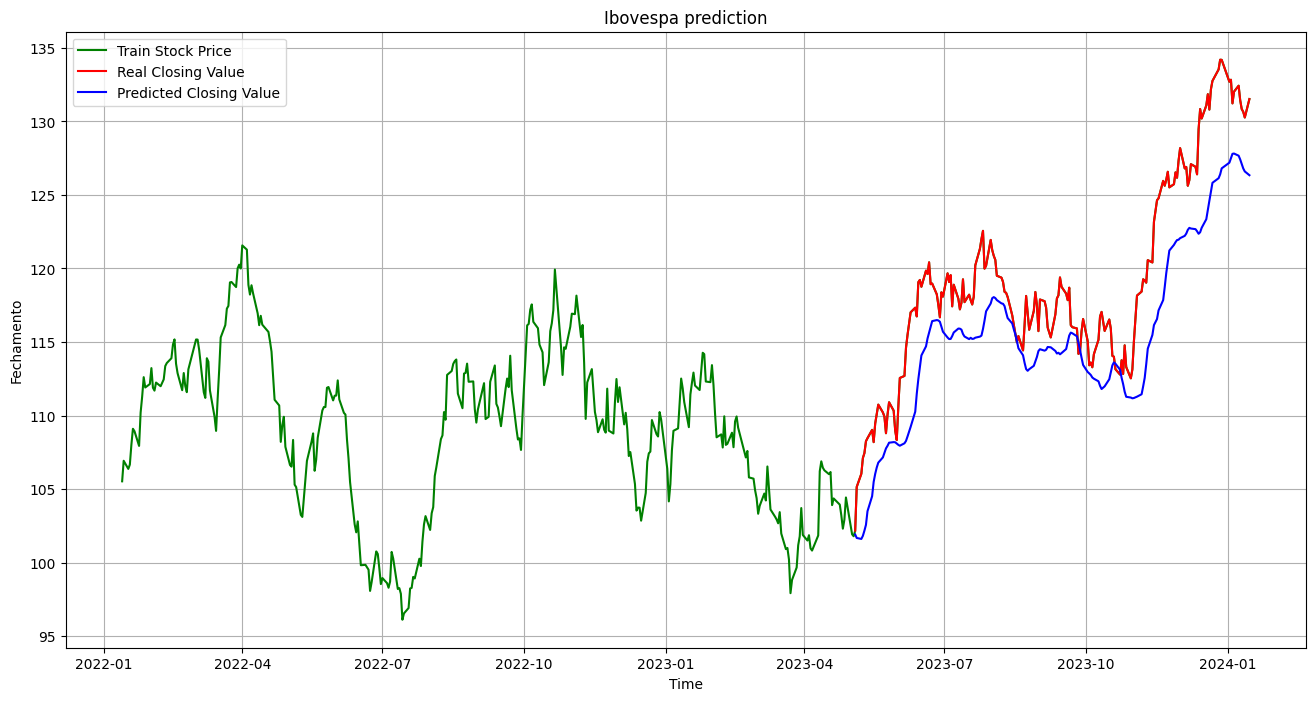

MSE: 18.20685208701816
MAE: 3.6799458419363833
RMSE: 4.2669488029525455


In [143]:
close_up_df = 500

plt.figure(figsize=(16,8))
plt.plot(ibovespa_merged.index[-close_up_df:], ibovespa_merged['Último'].tail(close_up_df), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Closing Value')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Closing Value')
plt.title('Ibovespa prediction')
plt.xlabel('Time')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

In [140]:
# Inicializando as variáveis
size = len(ibovespa_merged)
array_last_7_days = ibovespa_merged['Último'][size - 7: size].values
array_last_7_days = array_last_7_days.reshape(-1,1)
array_last_7_days = scaler.transform(array_last_7_days)

# Definindo o intervalo de datas para as previsões
start_date = '2024-01-15'
end_date = '2024-01-19'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Inicializando a lista para armazenar as previsões
predictions = []

# Loop para gerar previsões para cada data no intervalo
for current_date in date_range:
    # Fazendo a previsão para o próximo dia
    future_predict = model.predict(np.array([array_last_7_days]))
    future_predict = scaler.inverse_transform(future_predict)

    # Atualizando a lista de previsões
    predictions.append(future_predict[0, 0])

    # Transformando o valor previsto de volta para a escala original antes de atualizar a matriz
    future_predict_scaled = scaler.transform(future_predict)


    # Preparando os dados dos últimos 7 dias para a próxima iteração
    array_last_7_days = np.append(array_last_7_days[1:], future_predict_scaled).reshape(-1, 1)

# Convertendo as previsões para um DataFrame para facilitar a visualização e análise
forecast = pd.DataFrame(data={'Date': date_range, 'Predicted': predictions})

# Exibindo as previsões
print(forecast)

1/1 [==============================] - 0s 9ms/step
        Date   Predicted
0 2024-01-15  126.230904
1 2024-01-16  125.894180
2 2024-01-17  125.319893
3 2024-01-18  124.635170
4 2024-01-19  123.838310


In [141]:
# Avaliação manual dos datos de fechamento
# Dados dos preços reais das ações
data = {
    'Date': ['2024-01-19', '2024-01-18', '2024-01-17', '2024-01-16', '2024-01-15'],
    'Price': [127.636, 127.316, 128.524, 129.294, 131.521]
}

# Convertendo para DataFrame
actual_prices = pd.DataFrame(data)
actual_prices['Date'] = pd.to_datetime(actual_prices['Date'], format='%Y-%m-%d')
actual_prices.set_index('Date', inplace=True)
actual_prices.sort_index(inplace=True)
actual_prices, forecast


(              Price
 Date               
 2024-01-15  131.521
 2024-01-16  129.294
 2024-01-17  128.524
 2024-01-18  127.316
 2024-01-19  127.636,
         Date   Predicted
 0 2024-01-15  126.230904
 1 2024-01-16  125.894180
 2 2024-01-17  125.319893
 3 2024-01-18  124.635170
 4 2024-01-19  123.838310)

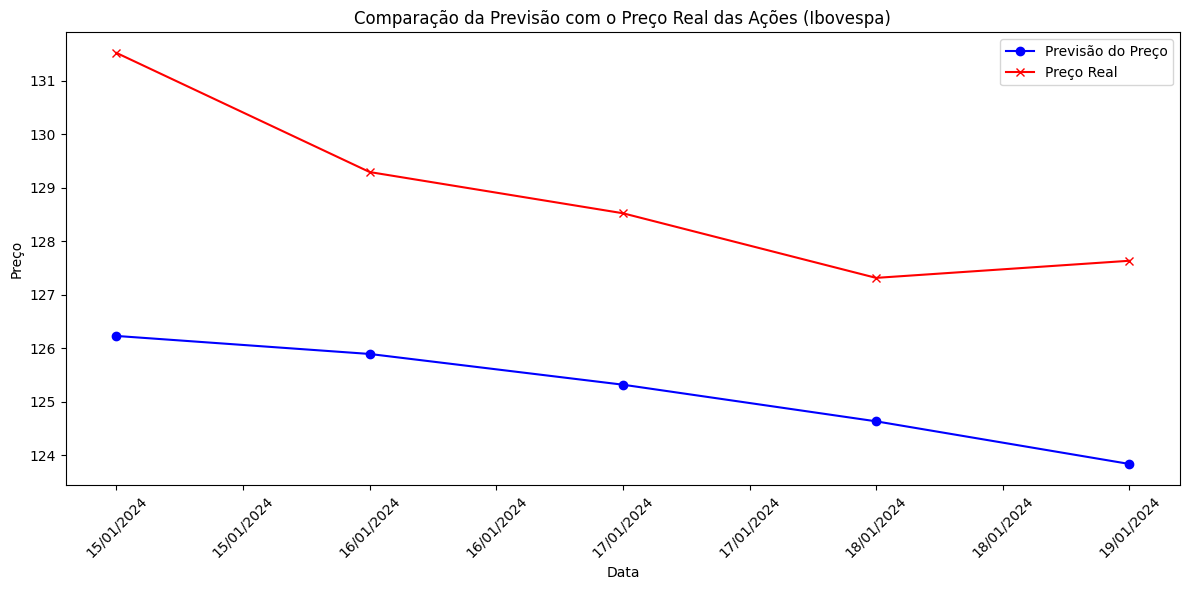

In [142]:
import matplotlib.pyplot as plt

# Continuando do código anterior para plotagem das previsões

# Criando um gráfico para visualizar as previsões e os preços reais
plt.figure(figsize=(12, 6))

# Plotando as previsões
plt.plot(forecast['Date'], forecast['Predicted'], color='blue', marker='o', linestyle='-', label='Previsão do Preço')

# Plotando os preços reais
plt.plot(actual_prices.index, actual_prices['Price'], color='red', marker='x', linestyle='-', label='Preço Real')

# Formatando a legenda do eixo x para datas
# Você pode ajustar o formato da data aqui. '%Y-%m-%d' representa o formato 'Ano-Mês-Dia'.
date_format = mdates.DateFormatter('%d/%m/%Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Adicionando título, rótulos e legenda
plt.title('Comparação da Previsão com o Preço Real das Ações (Ibovespa)')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

# Ajustando formatação da data
plt.xticks(rotation=45)
# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()